In [1]:
import sys
# sys.path.insert(0, '/Users/sbredenk/Repos/CORAL_nesc/CORAL')
sys.path.insert(0, '/Users/sbredenk/Repos/ORBIT_semitaut/ORBIT')
from CORAL import SharedLibrary, GlobalManager, Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yaml
import os

In [2]:
base = os.path.join(os.getcwd(), "analysis", "configs", "base.yaml")
base_float = os.path.join(os.getcwd(), "analysis", "configs", "base_float.yaml")
library = os.path.join(os.getcwd(), "analysis", "library")

In [3]:
base_baseline = os.path.join(os.getcwd(), "analysis", "pipelines", "base_baseline_pipeline.csv")
pipeline = Pipeline(base_baseline, base, base_float, enforce_feeders=True)

allocations = {
    "wtiv": [('example_heavy_lift_vessel', 2),('example_wtiv', 2)],
    "feeder": ('example_heavy_feeder', 6),
    "port": [('new_london', 1), ('new_bedford', 1), ('sbmt', 1), ('njwp', 1), ('searsport', 1), ('tradepoint', 1), ('portsmouth', 1), ('salem', 1)],
    "ahts_vessel": ('example_ahts_vessel', 2),
    "towing_vessel": ('example_towing_vessel', 2),
}

In [4]:
wtiv_dates = [dt.date(2025,1,1), dt.date(2030,1,1)]
manager = GlobalManager(pipeline.configs, allocations, library_path=library)
manager.add_future_resources('wtiv', 'example_wtiv', wtiv_dates)
manager.add_future_resources('wtiv', 'example_heavy_lift_vessel', wtiv_dates)
manager.run()

ORBIT library intialized at 'c:\Users\sbredenk\Repos\ORBIT_semitaut\ORBIT\library'


In [5]:
manager.library

In [6]:
df = pd.DataFrame(manager.logs).iloc[::-1]
df = df.reset_index(drop=True).reset_index()
# df['estimate_cod'] = np.zeros(len(df))
# df_pipeline = pd.read_csv(base_baseline)
# display(df_pipeline)

# for i,row in df.iterrows():
#     cod = df_pipeline.loc[df_pipeline]
#     df['estimated_cod'][i] = cod

In [7]:
sub_map = pipeline.projects[["name", "substructure"]].set_index("name").to_dict()['substructure']
df['substructure'] = [sub_map[name] for name in df['name']]

cod_map = pipeline.projects[["name", "estimated_cod"]].set_index("name").to_dict()['estimated_cod']
print(cod_map)
df['estimated_cod'] = [cod_map[name] for name in df['name']]

df['estimated_cod'] = pd.to_datetime(df['estimated_cod'], format='%Y')


df = df.replace('semisub','floating')
df = df.replace('monopile','fixed')
df = df.replace('jacket', 'fixed')
df['estimated_cod']

{'South Fork': 2024, 'Vineyard Wind 1': 2024, 'Revolution Wind 1': 2025, 'Atlantic Shores Offshore Wind South 1': 2027, 'CVOW-C': 2027, 'MarWin': 2027, 'Empire Wind 1': 2028, 'Momentum Wind': 2028, 'Sunrise Wind': 2029, 'Marine Research Array': 2029, 'Kitty Hawk North': 2030, 'MarWin Residual': 2030, 'SouthCoast 1 Phase 1 (Mayflower Wind 1)': 2030, 'SouthCoast 1 Phase 2 (Mayflower Wind 2)': 2030, 'SouthCoast Residual': 2030, 'Attentive Energy One': 2031, 'Attentive Energy Two': 2031, 'Community Offshore Wind 1': 2031, 'New England Wind 1 (Park City Wind, Vineyard Wind South)': 2031, 'New England Wind 2 (Commonwealth Wind, Vineyard Wind South)': 2031, 'Atlantic Shores Offshore Wind North': 2032, 'Atlantic Shores Offshore Wind South 2': 2032, 'Beacon Wind 1': 2032, 'Beacon Wind 2': 2032, 'Duke Energy/Cinergy': 2032, 'Leading Light Wind': 2032, 'Skipjack 1': 2032, 'Skipjack 2': 2032, 'Bay State Wind a (Revolution Wind 2)': 2033, 'Bay State Wind b': 2033, 'Excelsior Wind': 2033, 'Hypotheti

0    2042-01-01
1    2042-01-01
2    2041-01-01
3    2042-01-01
4    2041-01-01
        ...    
66   2027-01-01
67   2027-01-01
68   2025-01-01
69   2024-01-01
70   2024-01-01
Name: estimated_cod, Length: 71, dtype: datetime64[ns]

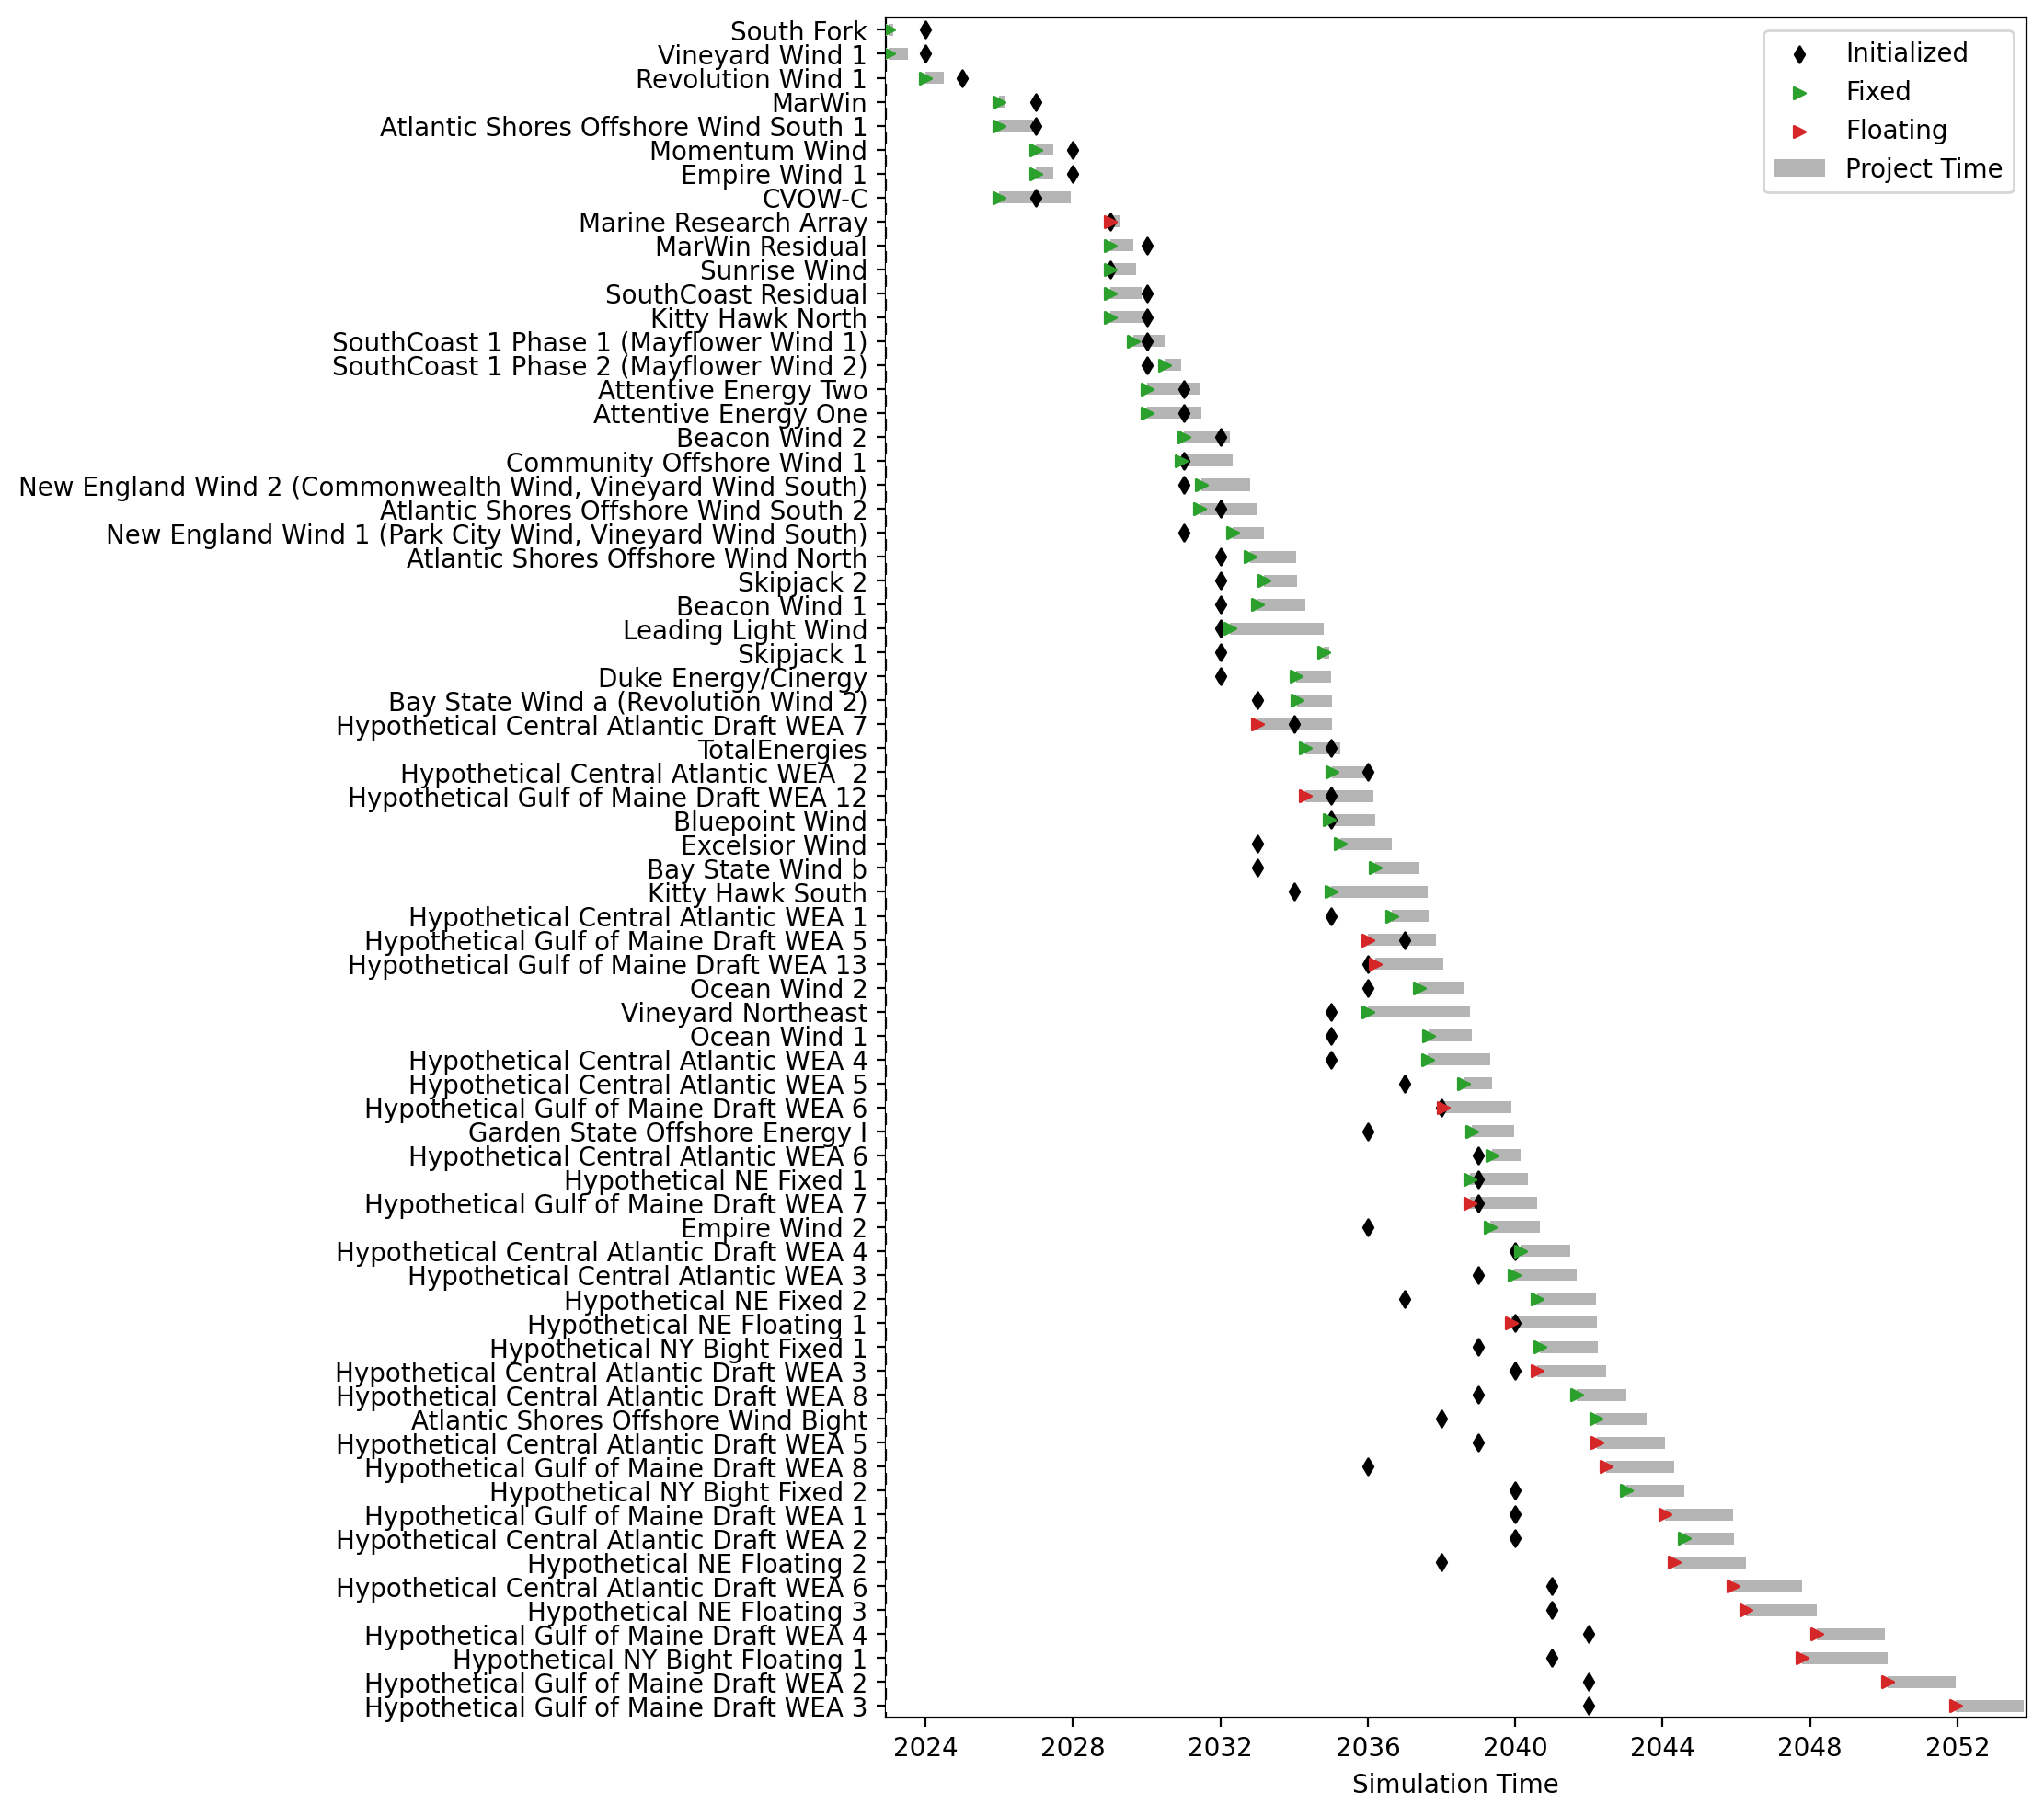

In [8]:
fig = plt.figure(figsize=(8, 12), dpi=200)
ax = fig.add_subplot(111)

color_map = {
    "fixed": "tab:green",
    "floating": "tab:red",
}

df["Date Finished"].plot(kind="barh", ax=ax, zorder=4, label="Project Time", color="#B5B5B5")
df["Date Started"].plot(kind="barh", color="w", ax=ax, zorder=4, label="__nolabel__")

df.plot(kind="scatter", x="estimated_cod", y="index", color='k', ax=ax, zorder=5, label="Initialized", marker="d")
# df.plot(kind="scatter", x="request-wtiv-date", y="index", color='tab:orange', ax=ax, zorder=5, label="WTIV", marker="x")

groups = df.groupby("substructure")
for name, group in groups:
    group.plot(kind="scatter", x="Date Started", y="index", ax=ax, marker=">", c=color_map[name], zorder=5, label=name.capitalize())

ax.set_xlabel("Simulation Time")
ax.set_ylabel("")
_ = ax.set_yticklabels(df['name'])

ax.legend()

ax.set_xlim(manager._start - dt.timedelta(days=30), df["Date Finished"].max() + dt.timedelta(days=30))
plt.savefig('analysis/results/test_418_double.png')